In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path

artifact_torch_root = Path().absolute().parent.parent

os.chdir(artifact_torch_root)

Path().absolute()

WindowsPath('c:/Users/hecto/Codebase/artifact-ml/artifact-torch')

In [3]:
import pandas as pd
import seaborn as sns
from artifact_core.binary_classification import BinaryFeatureSpec
from artifact_core.libs.resources.categorical.category_store.binary import BinaryCategoryStore
from artifact_experiment import DataSplit
from artifact_experiment.tracking import FilesystemTrackingClient
from matplotlib import pyplot as plt

from demos.binary_classification.config.constants import (
    EXPERIMENT_ID,
    LABEL_FEATURE,
    LS_CATEGORIES,
    LS_FEATURES,
    POSITIVE_CATEGORY,
    TRAINING_DATASET_PATH,
)
from demos.binary_classification.experiment.experiment import DemoBinaryClassificationExperiment
from demos.binary_classification.model.classifier import MLPClassifier

In [4]:
sns.set_theme(style="whitegrid", palette="colorblind")

In [5]:
df_train = pd.read_csv(artifact_torch_root / TRAINING_DATASET_PATH)

df_train

,weight,height,age,bmi,arthritis_true
0,73.1,168.7,41,25.7,1
1,116.3,166.6,21,41.9,1
2,99.9,158.8,23,39.6,1
3,89.9,180.4,64,27.6,1
4,56.7,173.8,32,18.8,0
...,...,...,...,...,...
9995,109.3,193.9,31,29.1,1
9996,112.3,152.3,64,48.4,1
9997,116.0,165.2,33,42.5,1
9998,74.8,172.2,76,25.2,0


In [6]:
class_spec = BinaryFeatureSpec(
    ls_categories=LS_CATEGORIES, positive_category=POSITIVE_CATEGORY, feature_name=LABEL_FEATURE
)

class_spec

BinaryFeatureSpec(feature_name='arthritis_true', categories=['0', '1'], positive_category='1', negative_category='0')

In [7]:
from artifact_torch.base.data.data_loader import DataLoader

from demos.binary_classification.config.constants import BATCH_SIZE, DROP_LAST, SHUFFLE
from demos.binary_classification.data.dataset import MLPClassifierDataset

data_loaders = {
    DataSplit.TRAIN: DataLoader(
        dataset=MLPClassifierDataset(
            df=df_train, ls_features=LS_FEATURES, label_feature=class_spec.feature_name
        ),
        batch_size=BATCH_SIZE,
        drop_last=DROP_LAST,
        shuffle=SHUFFLE,
    )
}

In [8]:
from artifact_torch.binary_classification.routine import BinaryClassificationRoutineData

classification_data = df_train.drop(class_spec.feature_name, axis=1)

id_to_category = df_train[class_spec.feature_name].to_dict()
true_category_store = BinaryCategoryStore.from_categories_and_spec(
    feature_spec=class_spec, id_to_category=id_to_category
)

artifact_routine_data = {
    DataSplit.TRAIN: BinaryClassificationRoutineData[pd.DataFrame](
        true_category_store=true_category_store, classification_data=classification_data
    )
}

In [9]:
model = MLPClassifier.build(class_spec=class_spec, ls_features=LS_FEATURES)

In [10]:
tracking_client = FilesystemTrackingClient.build(experiment_id=EXPERIMENT_ID)

In [11]:
experiment = DemoBinaryClassificationExperiment.build(
    model=model,
    data_loaders=data_loaders,
    artifact_routine_data=artifact_routine_data,
    artifact_routine_data_spec=class_spec,
    tracking_client=tracking_client,
)

In [12]:
experiment.run()

Training on device: cpu


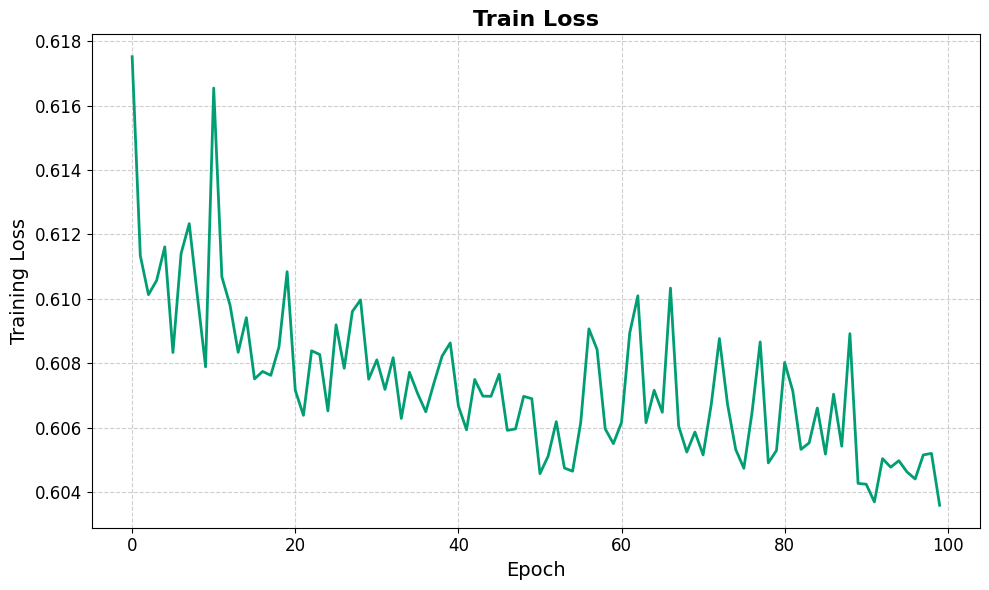

In [13]:
plt.figure(figsize=(10, 6))
experiment.epoch_scores["LOSS_TRAIN"].plot(color=sns.color_palette("colorblind")[2], linewidth=2)
plt.title("Train Loss", fontsize=16, fontweight="bold")
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Training Loss", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()